Loaded responses: 180 rows
Expanded to long: 540 model-rank rows
Models: ['microsam', 'unet_image_clip', 'unet_random']


,n,best,middle,worst,mean_rank,best_rate,worst_rate
model,,,,,,,
unet_image_clip,180,100,61,19,1.550000,0.555556,0.105556
unet_random,180,41,81,58,2.094444,0.227778,0.322222
microsam,180,39,38,103,2.355556,0.216667,0.572222


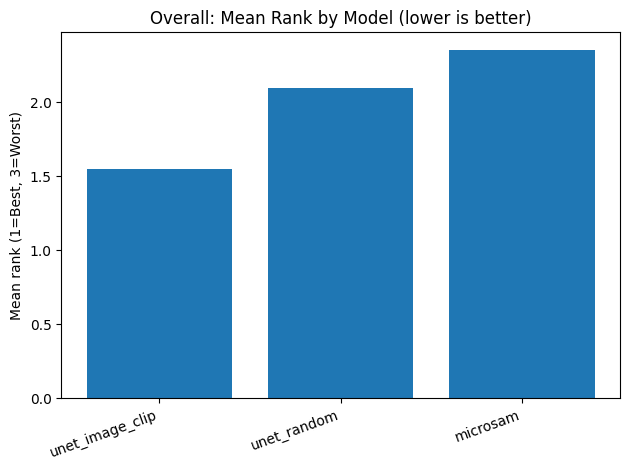

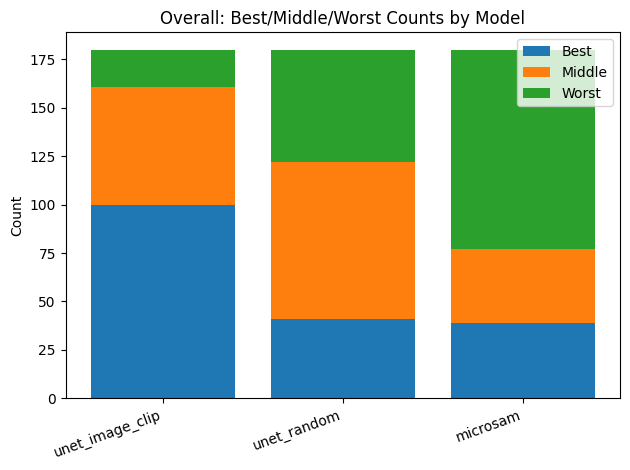

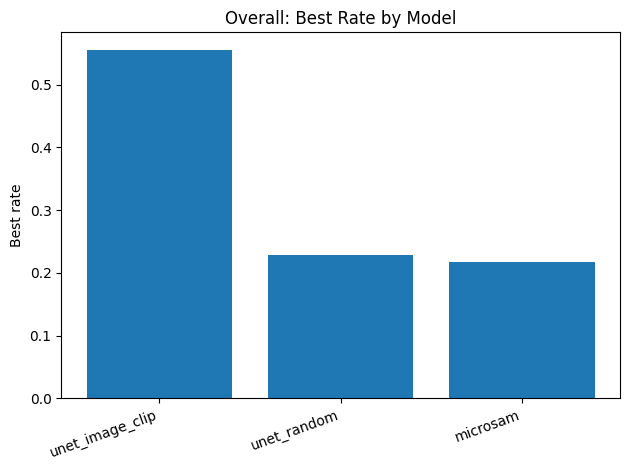


Mean rank by user (pivot):


model,microsam,unet_image_clip,unet_random
user_id,,,
Adina,2.516667,1.433333,2.050000
MW,2.333333,1.566667,2.100000
anonymous,2.216667,1.650000,2.133333


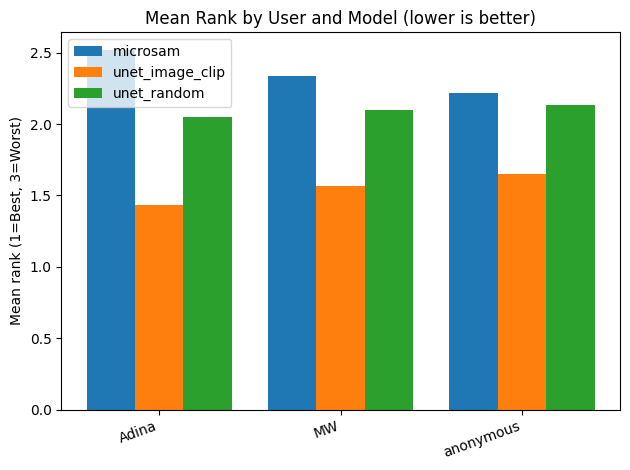

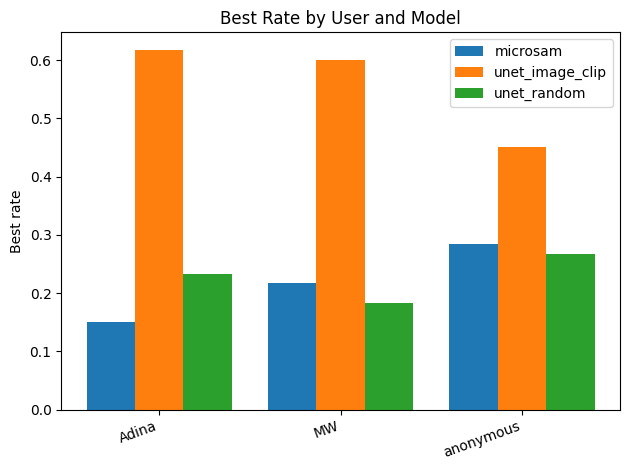


Mean rank by datatype (pivot):


model,microsam,unet_image_clip,unet_random
datatype,,,
amyloid_plaque,2.102564,1.410256,2.487179
cell_nucleus,2.971014,1.362319,1.666667
vessels,1.902778,1.805556,2.291667


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ============================================
# 0) CONFIG: point this to your downloaded file
# ============================================
# Example:
# FILE = Path("/Users/you/Downloads/Responses - Responses.tsv")
# FILE = Path("/Users/you/Downloads/Responses - Responses.csv")
FILE = Path("/midtier/paetzollab/scratch/ads4015/ssl_streamlit/segmentation_eval_results - Responses.csv")  # <-- CHANGE ME

RANK_TO_SCORE = {"Best": 1, "Middle": 2, "Worst": 3}

NEEDED_COLS = [
    "response_id","timestamp","user_id","sample_id","datatype","z",
    "rankA","rankB","rankC","map_A","map_B","map_C"
]

# ============================================
# 1) LOAD (auto-detect tab vs comma)
# ============================================
if not FILE.exists():
    raise FileNotFoundError(f"File not found: {FILE}\nUpdate FILE to your downloaded Google Sheet export path.")

with open(FILE, "r", encoding="utf-8") as f:
    first_line = f.readline()

sep = "\t" if "\t" in first_line else ","
df = pd.read_csv(FILE, sep=sep, dtype=str, keep_default_na=False)
df.columns = [c.strip() for c in df.columns]

missing = [c for c in NEEDED_COLS if c not in df.columns]
if missing:
    raise ValueError(
        f"Missing columns: {missing}\n"
        f"Found columns: {list(df.columns)}\n"
        "Did you export the correct tab (Responses) and include header row?"
    )

# Normalize basic fields
df["user_id"] = df["user_id"].astype(str).str.strip()
df["datatype"] = df["datatype"].astype(str).str.strip()
df["sample_id"] = df["sample_id"].astype(str).str.strip()
df["z"] = pd.to_numeric(df["z"], errors="coerce")

# ============================================
# 2) RESHAPE to "long": one row per (response, model)
# ============================================
rows = []
for _, r in df.iterrows():
    for lab in ["A", "B", "C"]:
        model = str(r[f"map_{lab}"]).strip()
        rank  = str(r[f"rank{lab}"]).strip()
        if rank not in RANK_TO_SCORE:
            continue
        rows.append({
            "response_id": r["response_id"],
            "timestamp": r["timestamp"],
            "user_id": r["user_id"],
            "sample_id": r["sample_id"],
            "datatype": r["datatype"],
            "z": r["z"],
            "label": lab,              # A/B/C shown to rater
            "model": model,            # true method
            "rank_label": rank,        # Best/Middle/Worst
            "rank_score": RANK_TO_SCORE[rank],  # 1/2/3
        })

long = pd.DataFrame(rows)

# Convenience indicators
long["is_best"] = (long["rank_score"] == 1).astype(int)
long["is_middle"] = (long["rank_score"] == 2).astype(int)
long["is_worst"] = (long["rank_score"] == 3).astype(int)

print("Loaded responses:", len(df), "rows")
print("Expanded to long:", len(long), "model-rank rows")
print("Models:", sorted(long["model"].unique()))

# ============================================
# 3) OVERALL SUMMARY TABLE
# ============================================
overall = (long.groupby("model")
           .agg(
               n=("rank_score","size"),
               best=("is_best","sum"),
               middle=("is_middle","sum"),
               worst=("is_worst","sum"),
               mean_rank=("rank_score","mean"),
           )
           .sort_values(["mean_rank","best"], ascending=[True, False])
          )

overall["best_rate"] = overall["best"] / overall["n"]
overall["worst_rate"] = overall["worst"] / overall["n"]

display(overall)

models = list(overall.index)

# ============================================
# 4) PLOTS: OVERALL
# ============================================

# (A) Mean rank (lower is better)
plt.figure()
plt.bar(models, overall.loc[models, "mean_rank"].values)
plt.ylabel("Mean rank (1=Best, 3=Worst)")
plt.title("Overall: Mean Rank by Model (lower is better)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# (B) Best/Middle/Worst counts (stacked)
plt.figure()
best = overall.loc[models, "best"].values
mid  = overall.loc[models, "middle"].values
worst= overall.loc[models, "worst"].values
plt.bar(models, best, label="Best")
plt.bar(models, mid, bottom=best, label="Middle")
plt.bar(models, worst, bottom=best+mid, label="Worst")
plt.ylabel("Count")
plt.title("Overall: Best/Middle/Worst Counts by Model")
plt.xticks(rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# (C) Best rate
plt.figure()
plt.bar(models, overall.loc[models, "best_rate"].values)
plt.ylabel("Best rate")
plt.title("Overall: Best Rate by Model")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# ============================================
# 5) BY USER_ID
# ============================================
by_user = (long.groupby(["user_id","model"])
           .agg(
               n=("rank_score","size"),
               best=("is_best","sum"),
               middle=("is_middle","sum"),
               worst=("is_worst","sum"),
               mean_rank=("rank_score","mean"),
           )
           .reset_index()
          )
by_user["best_rate"] = by_user["best"] / by_user["n"]

print("\nMean rank by user (pivot):")
display(by_user.pivot(index="user_id", columns="model", values="mean_rank"))

users = list(by_user["user_id"].unique())
models_all = sorted(long["model"].unique())

x = np.arange(len(users))
width = 0.8 / max(1, len(models_all))

# (A) Mean rank by user
plt.figure()
for i, m in enumerate(models_all):
    vals = []
    for u in users:
        row = by_user[(by_user.user_id==u) & (by_user.model==m)]
        vals.append(row["mean_rank"].iloc[0] if len(row) else np.nan)
    plt.bar(x + i*width, vals, width, label=m)
plt.ylabel("Mean rank (1=Best, 3=Worst)")
plt.title("Mean Rank by User and Model (lower is better)")
plt.xticks(x + width*(len(models_all)-1)/2, users, rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# (B) Best-rate by user
plt.figure()
for i, m in enumerate(models_all):
    vals = []
    for u in users:
        row = by_user[(by_user.user_id==u) & (by_user.model==m)]
        vals.append(row["best_rate"].iloc[0] if len(row) else np.nan)
    plt.bar(x + i*width, vals, width, label=m)
plt.ylabel("Best rate")
plt.title("Best Rate by User and Model")
plt.xticks(x + width*(len(models_all)-1)/2, users, rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================
# 6) OPTIONAL: BY DATATYPE
# ============================================
by_dtype = (long.groupby(["datatype","model"])
            .agg(
                n=("rank_score","size"),
                best=("is_best","sum"),
                middle=("is_middle","sum"),
                worst=("is_worst","sum"),
                mean_rank=("rank_score","mean"),
            )
            .reset_index()
           )
by_dtype["best_rate"] = by_dtype["best"] / by_dtype["n"]

print("\nMean rank by datatype (pivot):")
display(by_dtype.pivot(index="datatype", columns="model", values="mean_rank"))


Loaded: (180, 12)
ntr
5     84
15    96
Name: count, dtype: int64
Long format: (540, 10)


/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


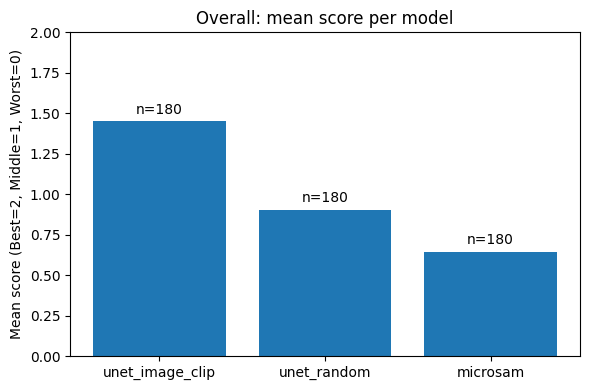

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["model", "rank"])


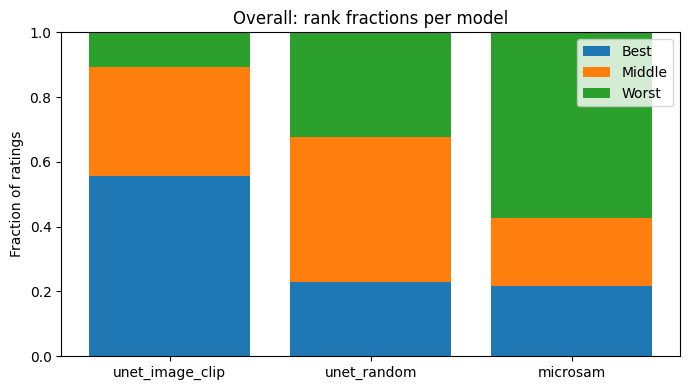

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


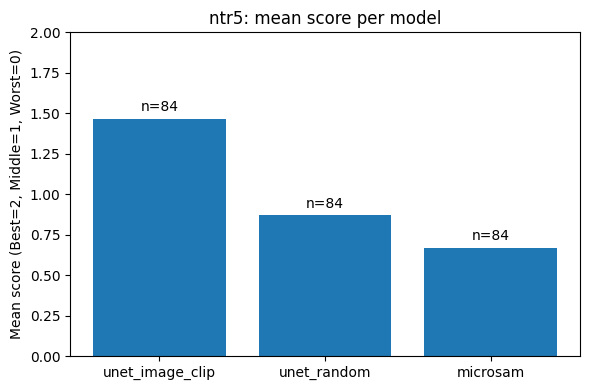

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["model", "rank"])


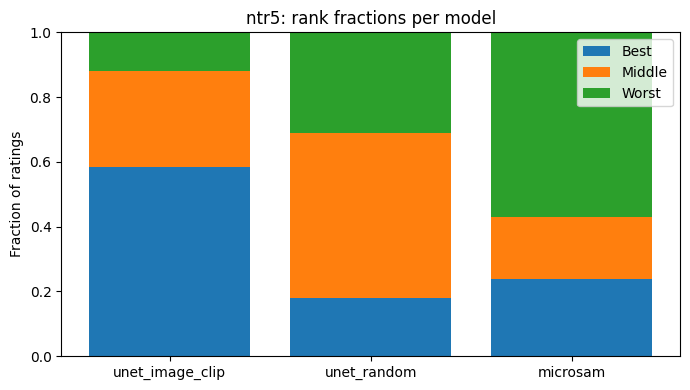

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


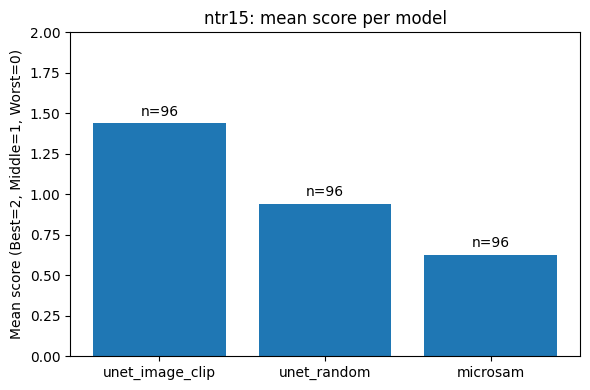

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["model", "rank"])


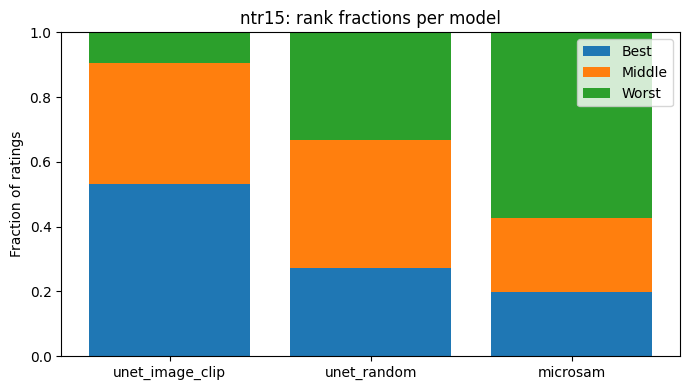

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)



User: Adina rows: 180


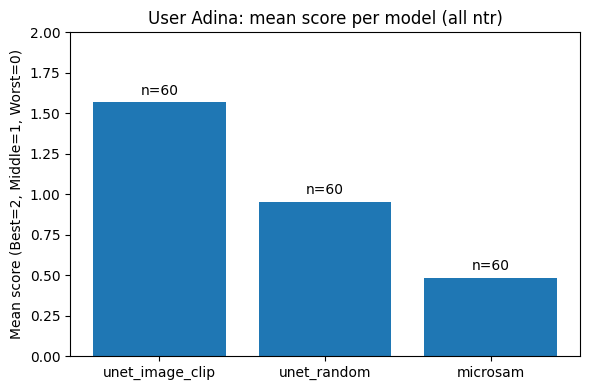

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


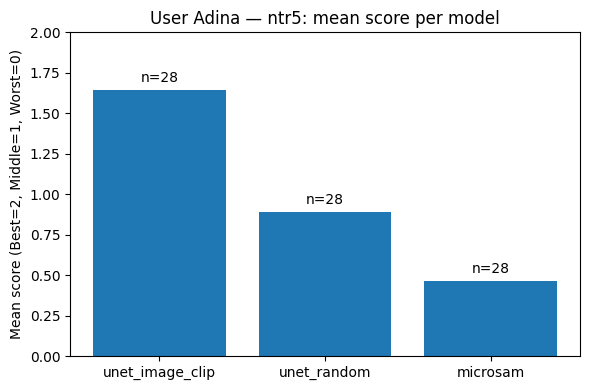

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


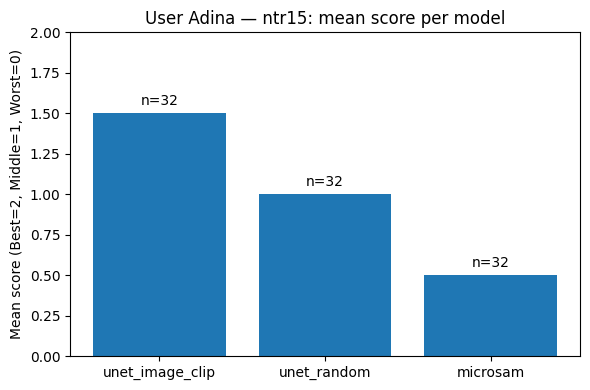

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)



User: MW rows: 180


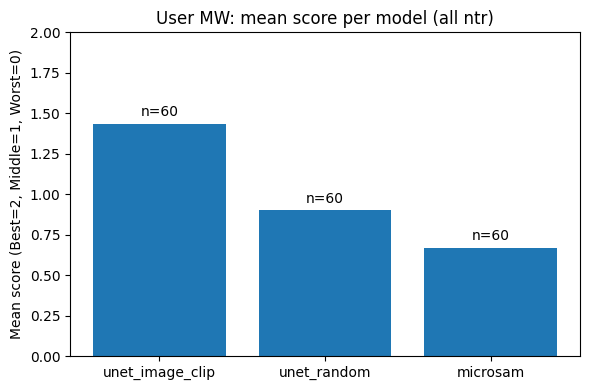

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


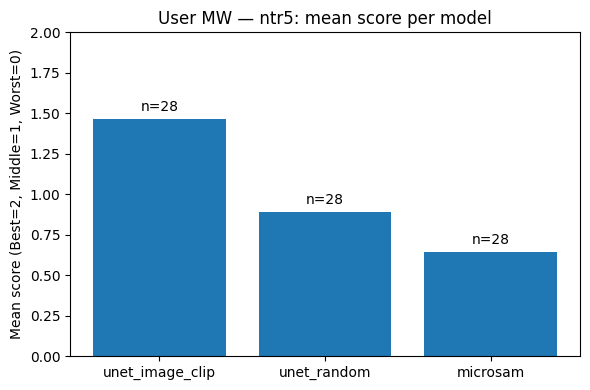

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


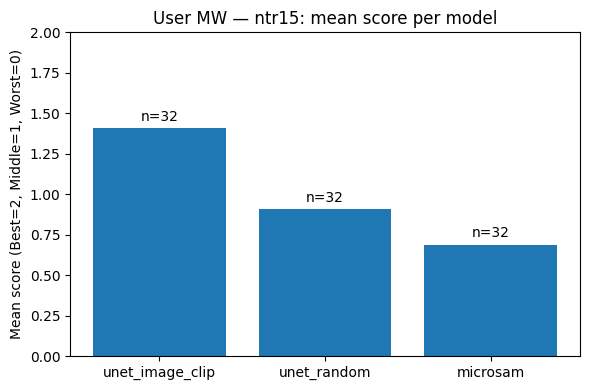

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)



User: anonymous rows: 180


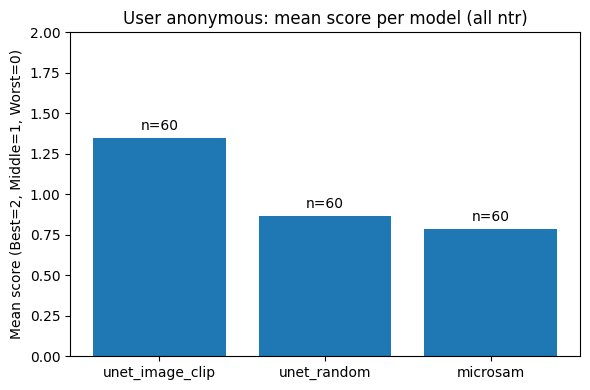

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


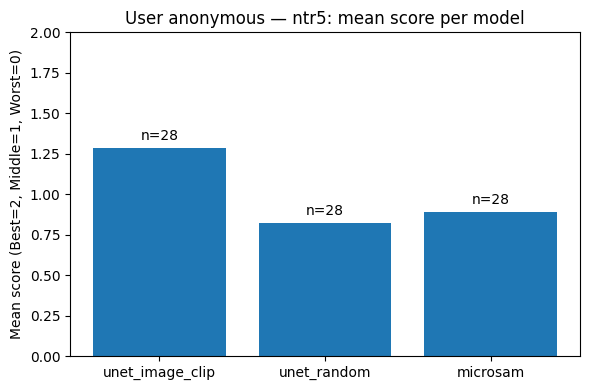

/tmp/ads4015/interactive/tmp/ipykernel_3654536/398897014.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)


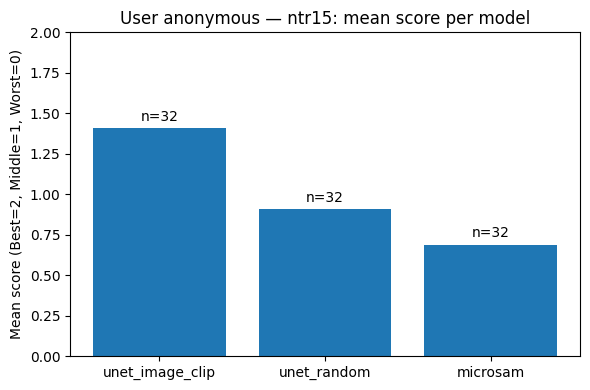

In [2]:
from pathlib import Path
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1) Load responses file
# ----------------------------
# EDIT THIS:
FILE = Path("/midtier/paetzollab/scratch/ads4015/ssl_streamlit/segmentation_eval_results - Responses.csv").expanduser()

# auto-detect delimiter
suffix = FILE.suffix.lower()
if suffix == ".tsv":
    df = pd.read_csv(FILE, sep="\t", dtype=str)
else:
    df = pd.read_csv(FILE, dtype=str)

print("Loaded:", df.shape)
df.head()

# ----------------------------
# 2) Basic cleaning / parsing
# ----------------------------
# Normalize rank -> score
RANK_TO_SCORE = {"Best": 2, "Middle": 1, "Worst": 0}

for c in ["rankA", "rankB", "rankC"]:
    df[c] = df[c].astype(str).str.strip()

# Parse ntr from sample_id.
# Your sample_id looks like: vessels_size5_patch_012_vol022_ch0_z64
# We'll treat size5 -> ntr=5, size15 -> ntr=15.
def parse_ntr(sample_id: str):
    m = re.search(r"_size(\d+)_", str(sample_id))
    return int(m.group(1)) if m else None

df["ntr"] = df["sample_id"].apply(parse_ntr)

# sanity check
print(df["ntr"].value_counts(dropna=False).sort_index())

# ----------------------------
# 3) Convert wide response rows -> long per-model scoring rows
# ----------------------------
# Each row has ranks A/B/C and mapping A/B/C -> actual model names.
# We'll turn each response into 3 rows: (sample_id, user_id, ntr, model, score)
rows = []
for _, r in df.iterrows():
    for label in ["A", "B", "C"]:
        model = r[f"map_{label}"]
        rank = r[f"rank{label}"]
        score = RANK_TO_SCORE.get(rank, np.nan)
        rows.append({
            "response_id": r.get("response_id", ""),
            "timestamp": r.get("timestamp", ""),
            "user_id": r.get("user_id", ""),
            "sample_id": r.get("sample_id", ""),
            "datatype": r.get("datatype", ""),
            "z": int(r.get("z", 0)) if str(r.get("z", "")).isdigit() else r.get("z", ""),
            "ntr": r.get("ntr", None),
            "model": model,
            "rank": rank,
            "score": score,
        })

long = pd.DataFrame(rows)
print("Long format:", long.shape)
long.head()

# Optional: enforce model ordering
MODEL_ORDER = ["unet_image_clip", "unet_random", "microsam"]
long["model"] = pd.Categorical(long["model"], categories=MODEL_ORDER, ordered=True)

# ----------------------------
# 4) Helper plotting functions
# ----------------------------
def plot_mean_score(data: pd.DataFrame, title: str):
    """
    Bar plot of mean score per model (Best=2, Middle=1, Worst=0).
    """
    g = data.groupby("model")["score"].agg(["mean", "count"]).reindex(MODEL_ORDER)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(g.index.astype(str), g["mean"].values)
    ax.set_ylim(0, 2)
    ax.set_ylabel("Mean score (Best=2, Middle=1, Worst=0)")
    ax.set_title(title)
    # annotate counts
    for i, (m, row) in enumerate(g.iterrows()):
        ax.text(i, row["mean"] + 0.03, f"n={int(row['count'])}", ha="center", va="bottom")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_rank_fractions(data: pd.DataFrame, title: str):
    """
    Stacked fractions per model: fraction Best/Middle/Worst.
    """
    frac = (
        data.groupby(["model", "rank"])
            .size()
            .unstack(fill_value=0)
            .reindex(index=MODEL_ORDER, columns=["Best", "Middle", "Worst"])
    )
    frac = frac.div(frac.sum(axis=1), axis=0)

    fig, ax = plt.subplots(figsize=(7, 4))
    bottom = np.zeros(len(frac))
    for rk in ["Best", "Middle", "Worst"]:
        vals = frac[rk].values
        ax.bar(frac.index.astype(str), vals, bottom=bottom, label=rk)
        bottom += vals

    ax.set_ylim(0, 1)
    ax.set_ylabel("Fraction of ratings")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------
# 5) Overall plots (all ntr together)
# ----------------------------
plot_mean_score(long, "Overall: mean score per model")
plot_rank_fractions(long, "Overall: rank fractions per model")

# ----------------------------
# 6) Plots separated by ntr (ntr5 vs ntr15)
# ----------------------------
for ntr in sorted([x for x in long["ntr"].dropna().unique()]):
    sub = long[long["ntr"] == ntr]
    plot_mean_score(sub, f"ntr{ntr}: mean score per model")
    plot_rank_fractions(sub, f"ntr{ntr}: rank fractions per model")

# ----------------------------
# 7) By user_id, separated by ntr
# ----------------------------
users = sorted(long["user_id"].dropna().unique())
for user in users:
    udata = long[long["user_id"] == user]
    print("\nUser:", user, "rows:", len(udata))
    plot_mean_score(udata, f"User {user}: mean score per model (all ntr)")
    for ntr in sorted([x for x in udata["ntr"].dropna().unique()]):
        sub = udata[udata["ntr"] == ntr]
        plot_mean_score(sub, f"User {user} — ntr{ntr}: mean score per model")


Loaded 180 rows from /midtier/paetzollab/scratch/ads4015/ssl_streamlit/segmentation_eval_results - Responses.csv


,response_id,timestamp,user_id,sample_id,datatype,z,rankA,rankB,rankC,map_A,map_B,map_C
0,Adina::vessels_size5_patch_012_vol022_ch0_z64,2026-01-26 06:05:49,Adina,vessels_size5_patch_012_vol022_ch0_z64,vessels,64,Middle,Worst,Best,unet_random,unet_image_clip,microsam
1,Adina::cell_nucleus_size5_patch_008_vol002_ch0...,2026-01-26 06:06:35,Adina,cell_nucleus_size5_patch_008_vol002_ch0_z32,cell_nucleus,32,Worst,Middle,Best,microsam,unet_random,unet_image_clip
2,Adina::cell_nucleus_size5_patch_020_vol011_ch0...,2026-01-26 06:06:54,Adina,cell_nucleus_size5_patch_020_vol011_ch0_z32,cell_nucleus,32,Worst,Best,Middle,microsam,unet_image_clip,unet_random
3,Adina::cell_nucleus_size5_patch_010_vol000_ch0...,2026-01-26 06:07:28,Adina,cell_nucleus_size5_patch_010_vol000_ch0_z32,cell_nucleus,32,Middle,Worst,Best,unet_random,microsam,unet_image_clip
4,Adina::amyloid_plaque_size15_patch_003_vol016_...,2026-01-26 06:07:36,Adina,amyloid_plaque_size15_patch_003_vol016_ch0_z48,amyloid_plaque,48,Best,Middle,Worst,unet_image_clip,unet_random,microsam


Long format rows: 540 (should be 3x wide rows)


,response_id,timestamp,user_id,sample_id,datatype,z,ntr,label,model,rank,score
0,Adina::vessels_size5_patch_012_vol022_ch0_z64,2026-01-26 06:05:49,Adina,vessels_size5_patch_012_vol022_ch0_z64,vessels,64,5,A,unet_random,Middle,1
1,Adina::vessels_size5_patch_012_vol022_ch0_z64,2026-01-26 06:05:49,Adina,vessels_size5_patch_012_vol022_ch0_z64,vessels,64,5,B,unet_image_clip,Worst,0
2,Adina::vessels_size5_patch_012_vol022_ch0_z64,2026-01-26 06:05:49,Adina,vessels_size5_patch_012_vol022_ch0_z64,vessels,64,5,C,microsam,Best,2
3,Adina::cell_nucleus_size5_patch_008_vol002_ch0...,2026-01-26 06:06:35,Adina,cell_nucleus_size5_patch_008_vol002_ch0_z32,cell_nucleus,32,5,A,microsam,Worst,0
4,Adina::cell_nucleus_size5_patch_008_vol002_ch0...,2026-01-26 06:06:35,Adina,cell_nucleus_size5_patch_008_vol002_ch0_z32,cell_nucleus,32,5,B,unet_random,Middle,1


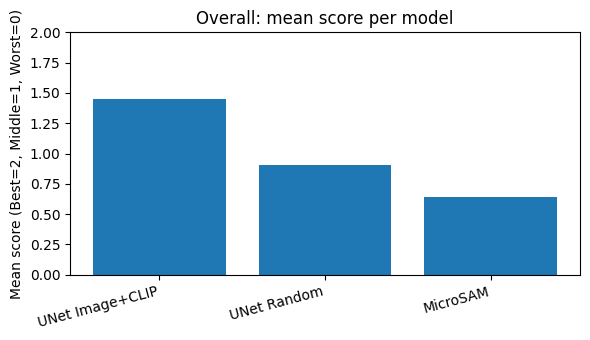

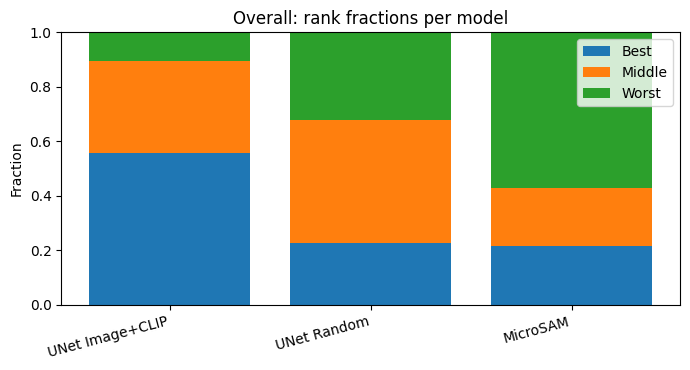

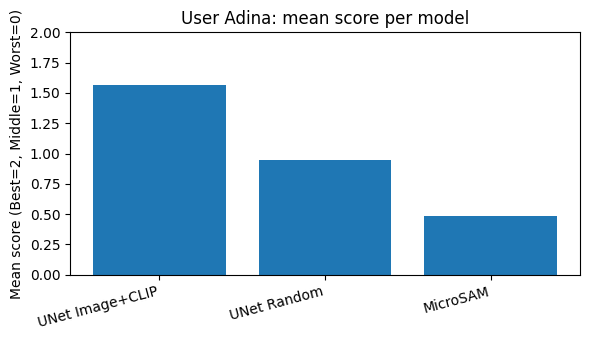

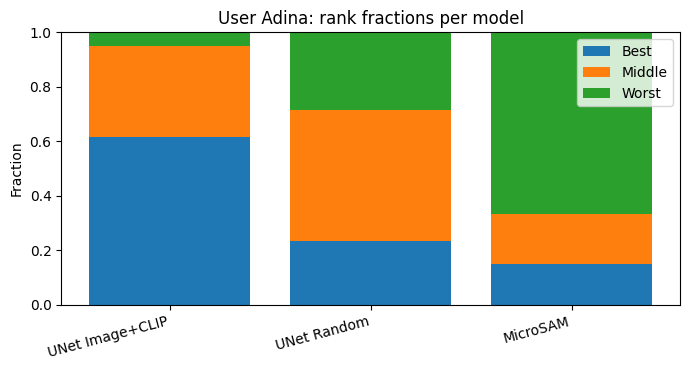

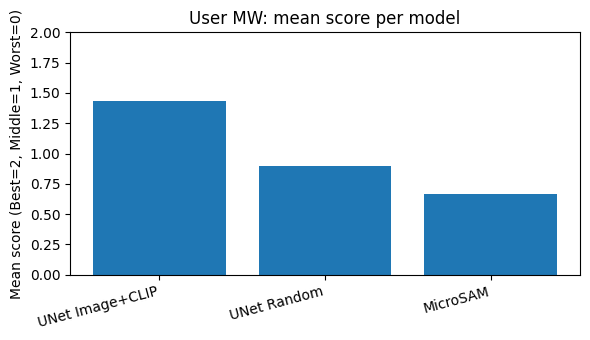

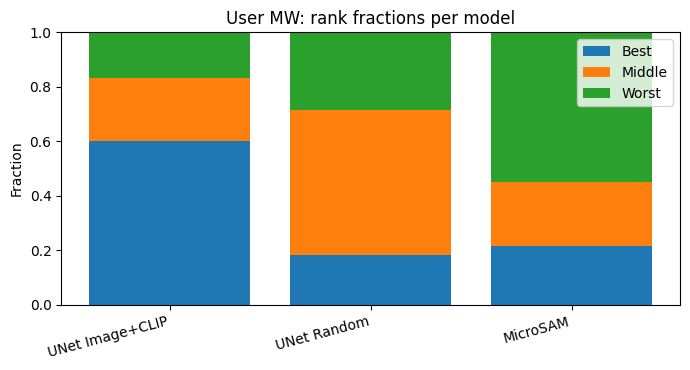

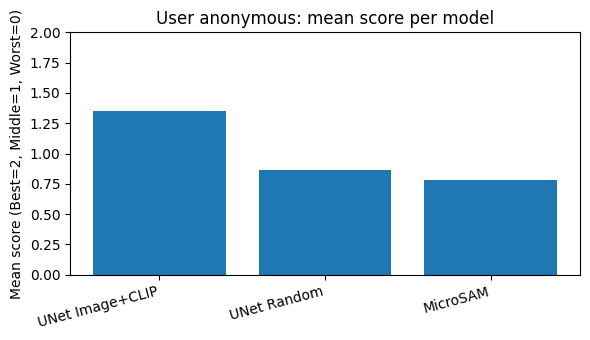

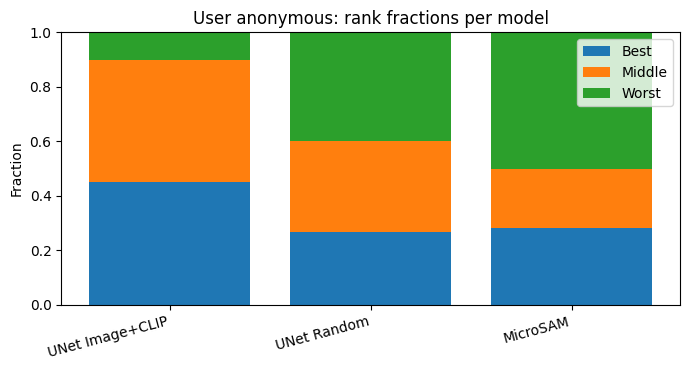

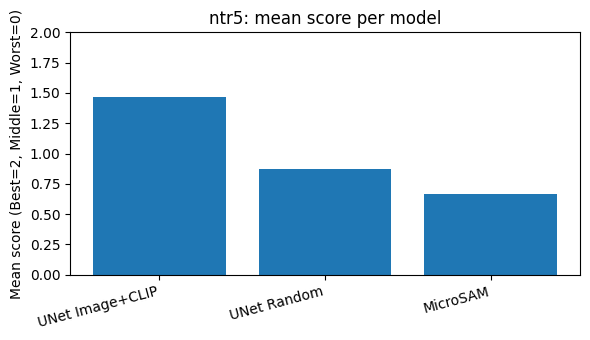

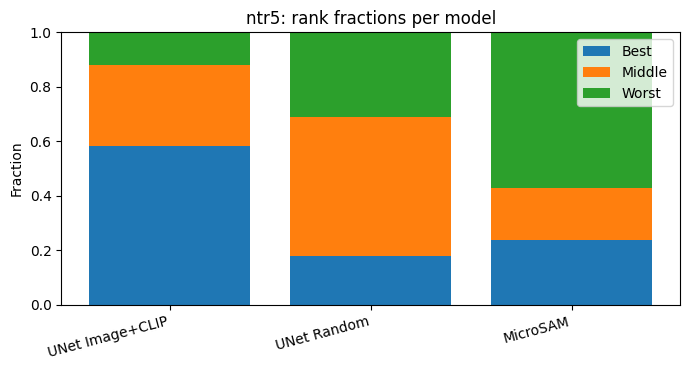

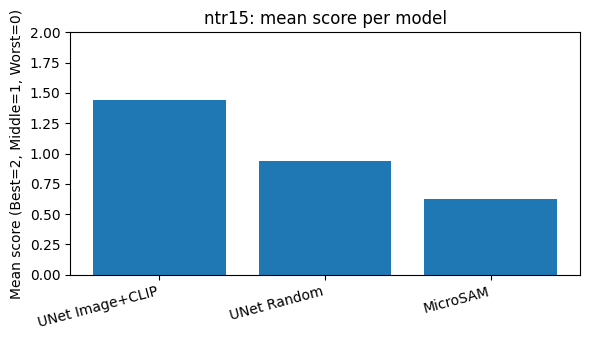

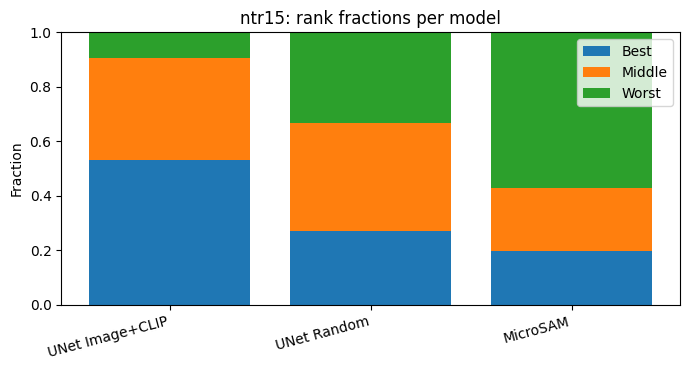

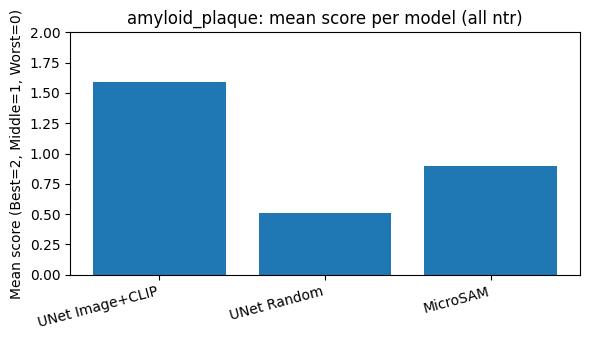

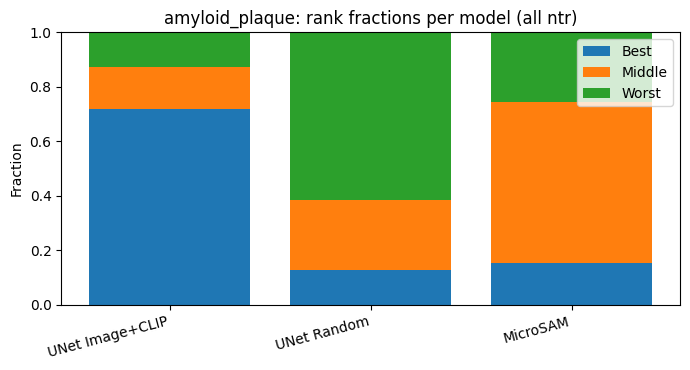

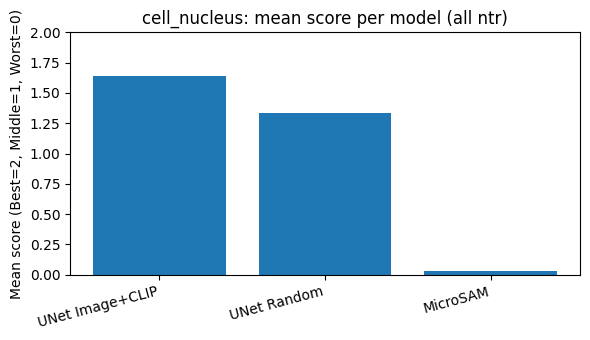

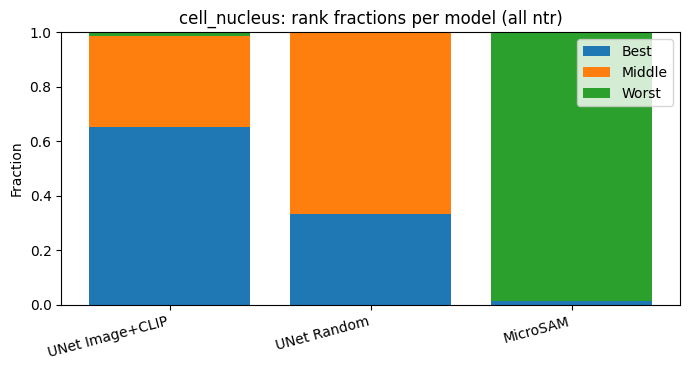

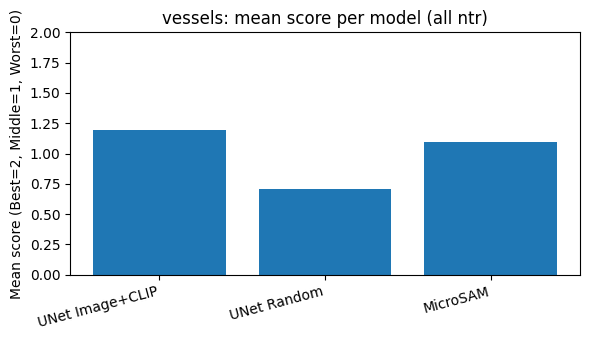

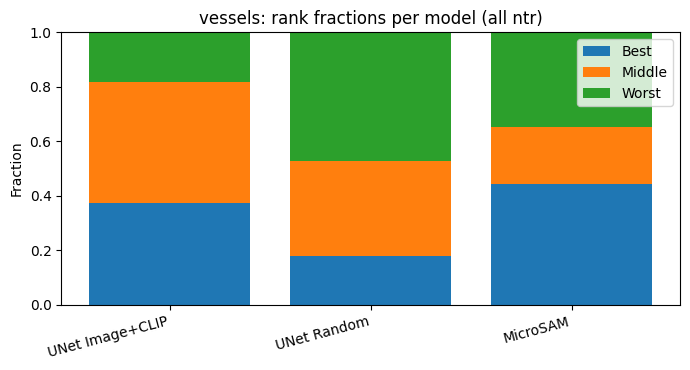

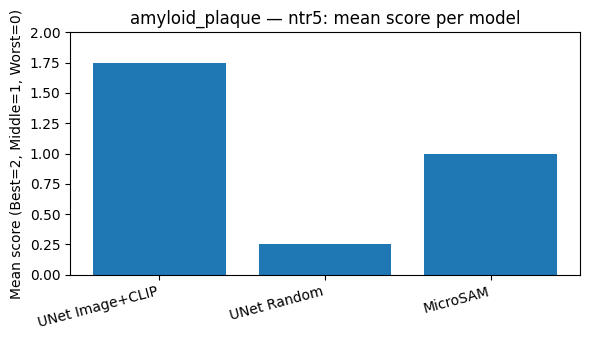

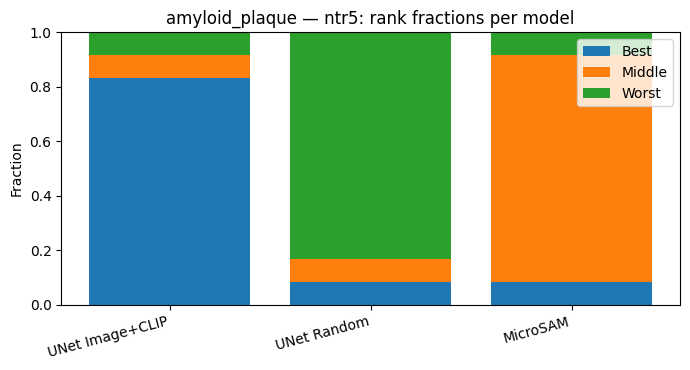

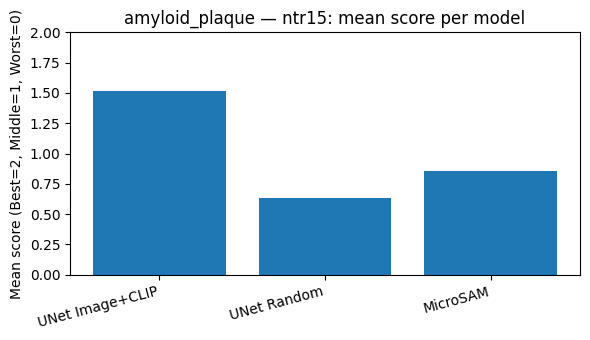

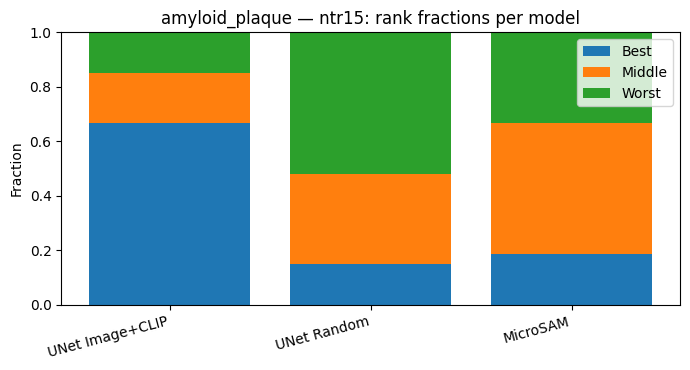

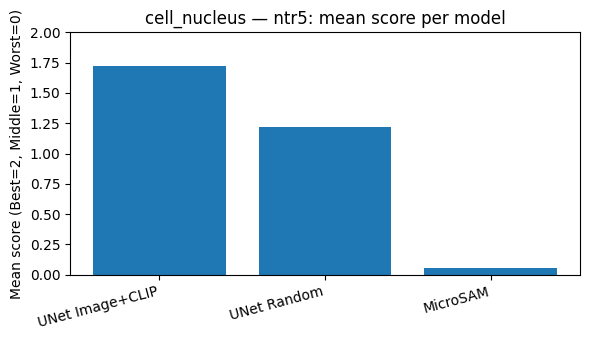

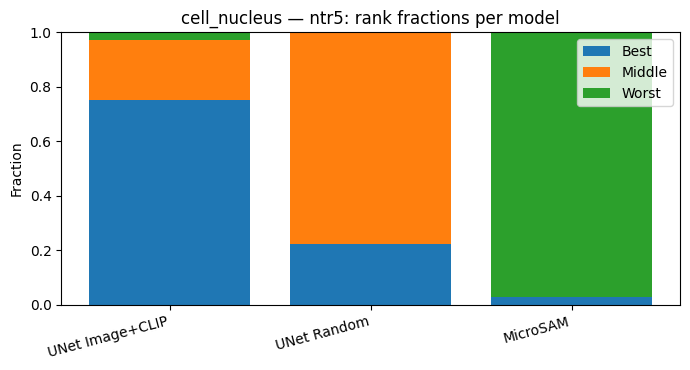

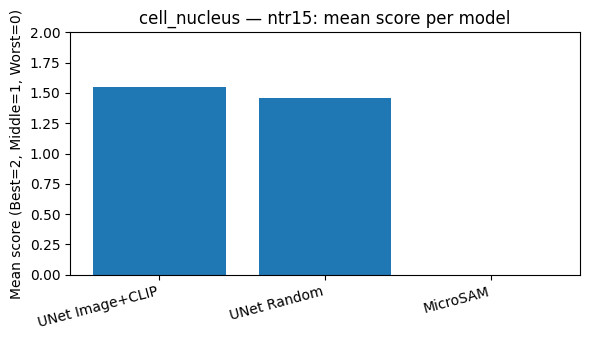

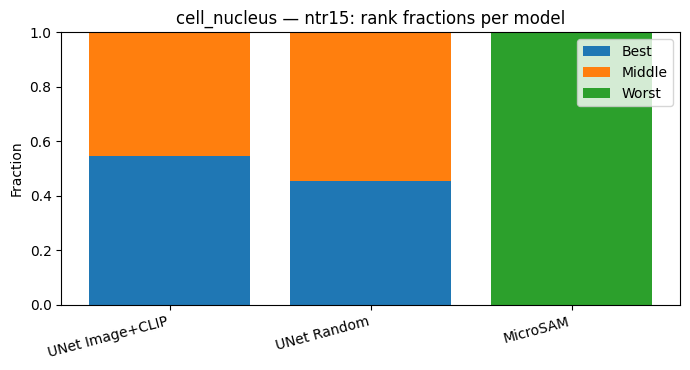

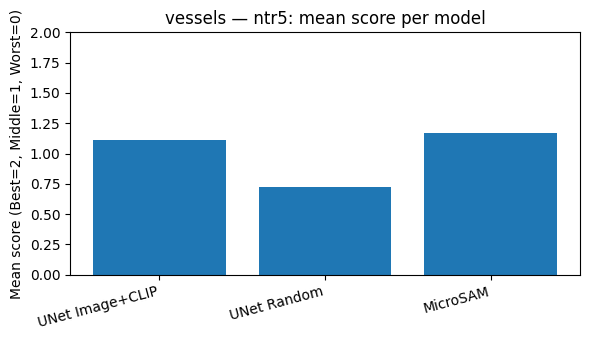

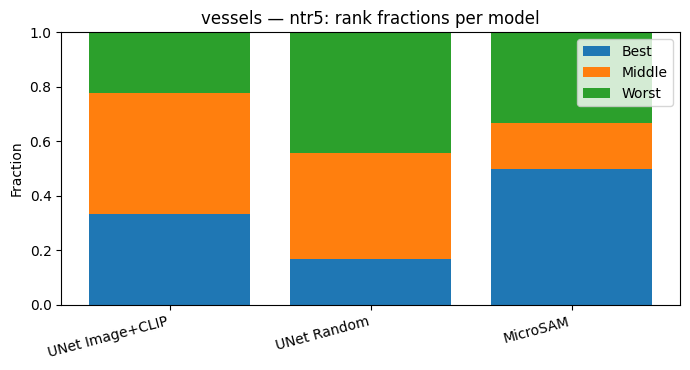

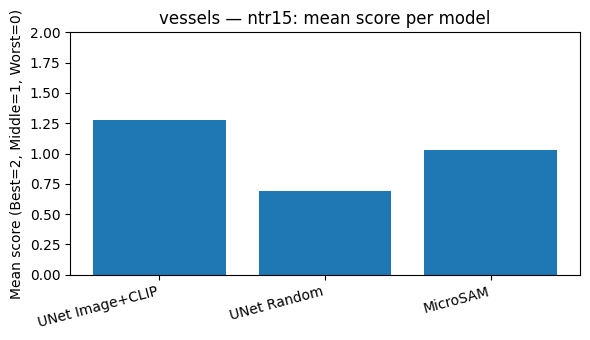

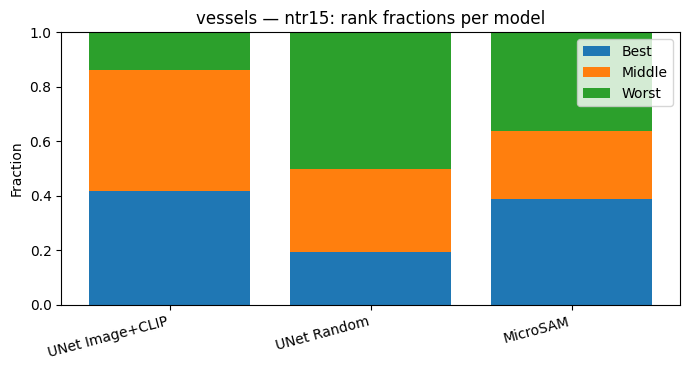


Mean score by datatype and ntr:


model               unet_image_clip  unet_random  microsam
datatype       ntr                                        
amyloid_plaque 5              1.750        0.250     1.000
               15             1.519        0.630     0.852
cell_nucleus   5              1.722        1.222     0.056
               15             1.545        1.455     0.000
vessels        5              1.111        0.722     1.167
               15             1.278        0.694     1.028


Rank fractions by datatype, ntr, model:


rank                                 Best  Middle  Worst
datatype       ntr model                                
amyloid_plaque 5   microsam         0.083   0.833  0.083
                   unet_image_clip  0.833   0.083  0.083
                   unet_random      0.083   0.083  0.833
               15  microsam         0.185   0.481  0.333
                   unet_image_clip  0.667   0.185  0.148
                   unet_random      0.148   0.333  0.519
cell_nucleus   5   microsam         0.028   0.000  0.972
                   unet_image_clip  0.750   0.222  0.028
                   unet_random      0.222   0.778  0.000
               15  microsam         0.000   0.000  1.000
                   unet_image_clip  0.545   0.455  0.000
                   unet_random      0.455   0.545  0.000
vessels        5   microsam         0.500   0.167  0.333
                   unet_image_clip  0.333   0.444  0.222
                   unet_random      0.167   0.389  0.444
               15  microsam         0.389   0.250  0.361
                   unet_image_clip  0.417   0.444  0.139
                   unet_random      0.194   0.306  0.500

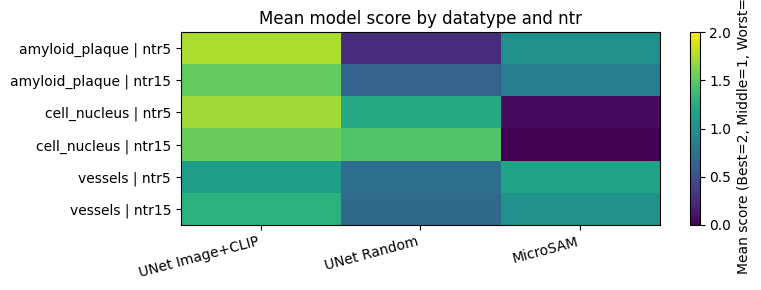

In [3]:
# ============================================================
# SEGMENTATION RANKING EVALUATION NOTEBOOK (COMPLETE)
# - Reads Google Sheet export (CSV/TSV) you download locally
# - Computes per-model scores from blinded A/B/C ranks + mapping
# - Plots overall, by user_id, by ntr (ntr5 vs ntr15), and by datatype
# ============================================================

import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------
# 0) CONFIG
# ----------------------------

# Put your downloaded file path here
RESPONSES_PATH = Path("/midtier/paetzollab/scratch/ads4015/ssl_streamlit/segmentation_eval_results - Responses.csv")  # <-- change me

# Model order + readable names (optional)
MODEL_ORDER = ["unet_image_clip", "unet_random", "microsam"]
MODEL_PRETTY = {
    "unet_image_clip": "UNet Image+CLIP",
    "unet_random": "UNet Random",
    "microsam": "MicroSAM",
}

# rank -> numeric score (bigger is better)
RANK_TO_SCORE = {"Best": 2, "Middle": 1, "Worst": 0}


# ----------------------------
# 1) LOAD RESPONSES
# ----------------------------

def read_responses(path: Path) -> pd.DataFrame:
    """
    Reads the downloaded Google Sheet export.
    Works for CSV or TSV (tab-separated).
    """
    if not path.exists():
        raise FileNotFoundError(f"Responses file not found: {path.resolve()}")

    # try CSV first, then TSV fallback
    try:
        df = pd.read_csv(path, dtype=str, keep_default_na=False)
    except Exception:
        df = pd.read_csv(path, sep="\t", dtype=str, keep_default_na=False)

    # standardize expected columns if present
    expected = [
        "response_id", "timestamp", "user_id", "sample_id", "datatype", "z",
        "rankA", "rankB", "rankC", "map_A", "map_B", "map_C"
    ]
    missing = [c for c in expected if c not in df.columns]
    if missing:
        raise ValueError(
            f"Missing expected columns: {missing}\n"
            f"Found columns: {list(df.columns)}"
        )

    # normalize whitespace
    for c in expected:
        df[c] = df[c].astype(str).str.strip()

    # coerce z to int if possible
    df["z"] = pd.to_numeric(df["z"], errors="coerce").astype("Int64")

    return df


df = read_responses(RESPONSES_PATH)
print(f"Loaded {len(df)} rows from {RESPONSES_PATH.resolve()}")
display(df.head())


# ----------------------------
# 2) PARSE NTR (train size) FROM sample_id
# ----------------------------

def extract_ntr(sample_id: str):
    """
    Extract ntr from sample_id strings like:
      vessels_size5_patch_012_vol022_ch0_z64  -> 5
    If not found, returns None.
    """
    m = re.search(r"_size(\d+)_", str(sample_id))
    if m:
        return int(m.group(1))
    return None


df["ntr"] = df["sample_id"].apply(extract_ntr).astype("Int64")


# ----------------------------
# 3) CONVERT WIDE -> LONG (one row per (response, model))
# ----------------------------

def wide_to_long(df_wide: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a long dataframe with one row per model per response:
      columns: response_id, user_id, sample_id, datatype, z, ntr, model, rank, score
    """
    rows = []
    for _, r in df_wide.iterrows():
        # mapping from label to actual model name
        map_label_to_model = {
            "A": r["map_A"],
            "B": r["map_B"],
            "C": r["map_C"],
        }
        # label -> rank string
        label_to_rank = {
            "A": r["rankA"],
            "B": r["rankB"],
            "C": r["rankC"],
        }

        # build one row per label/model
        for label in ["A", "B", "C"]:
            model = map_label_to_model.get(label, "").strip()
            rank = label_to_rank.get(label, "").strip()
            score = RANK_TO_SCORE.get(rank, np.nan)

            rows.append({
                "response_id": r["response_id"],
                "timestamp": r["timestamp"],
                "user_id": r["user_id"],
                "sample_id": r["sample_id"],
                "datatype": r["datatype"],
                "z": int(r["z"]) if pd.notna(r["z"]) else np.nan,
                "ntr": int(r["ntr"]) if pd.notna(r["ntr"]) else np.nan,
                "label": label,
                "model": model,
                "rank": rank,
                "score": score,
            })

    long = pd.DataFrame(rows)

    # basic sanity checks
    bad_models = long[~long["model"].isin(MODEL_ORDER)]
    if len(bad_models) > 0:
        print("[WARN] Found model names not in MODEL_ORDER. Examples:")
        display(bad_models[["model"]].drop_duplicates().head(10))

    bad_ranks = long[~long["rank"].isin(RANK_TO_SCORE.keys())]
    if len(bad_ranks) > 0:
        print("[WARN] Found rank values not in {Best, Middle, Worst}. Examples:")
        display(bad_ranks[["rank"]].drop_duplicates().head(10))

    return long


long = wide_to_long(df)
print(f"Long format rows: {len(long)} (should be 3x wide rows)")
display(long.head())


# ----------------------------
# 4) PLOTTING HELPERS
# ----------------------------

def _pretty_model(m: str) -> str:
    return MODEL_PRETTY.get(m, m)

def plot_mean_score(sub: pd.DataFrame, title: str):
    """
    Bar plot of mean score per model (Best=2, Middle=1, Worst=0).
    """
    g = (
        sub.groupby("model")["score"]
        .mean()
        .reindex(MODEL_ORDER)
    )
    # remove models not present
    g = g.dropna()

    plt.figure(figsize=(6, 3.5))
    plt.bar([_pretty_model(x) for x in g.index], g.values)
    plt.ylim(0, 2)
    plt.ylabel("Mean score (Best=2, Middle=1, Worst=0)")
    plt.title(title)
    plt.xticks(rotation=15, ha="right")
    plt.tight_layout()
    plt.show()

def plot_rank_fractions(sub: pd.DataFrame, title: str):
    """
    Stacked bar plot of fractions of Best/Middle/Worst per model.
    """
    # counts per (model, rank)
    ct = (
        sub.groupby(["model", "rank"])
        .size()
        .unstack("rank", fill_value=0)
    )

    # ensure all rank cols exist
    for rk in ["Best", "Middle", "Worst"]:
        if rk not in ct.columns:
            ct[rk] = 0
    ct = ct[["Best", "Middle", "Worst"]]

    # order models
    ct = ct.reindex(MODEL_ORDER).dropna(how="all")

    # convert to fractions
    frac = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0)

    plt.figure(figsize=(7, 3.8))
    bottom = np.zeros(len(frac))
    x = np.arange(len(frac.index))

    for rk in ["Best", "Middle", "Worst"]:
        vals = frac[rk].fillna(0).values
        plt.bar(x, vals, bottom=bottom, label=rk)
        bottom += vals

    plt.xticks(x, [_pretty_model(m) for m in frac.index], rotation=15, ha="right")
    plt.ylim(0, 1)
    plt.ylabel("Fraction")
    plt.title(title)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# ----------------------------
# 5) OVERALL RESULTS
# ----------------------------

plot_mean_score(long, "Overall: mean score per model")
plot_rank_fractions(long, "Overall: rank fractions per model")


# ----------------------------
# 6) RESULTS BY USER
# ----------------------------

users = sorted(long["user_id"].dropna().unique())
for u in users:
    sub = long[long["user_id"] == u]
    plot_mean_score(sub, f"User {u}: mean score per model")
    plot_rank_fractions(sub, f"User {u}: rank fractions per model")


# ----------------------------
# 7) RESULTS BY NTR (ntr5 vs ntr15 separately)
# ----------------------------

ntrs = sorted([int(x) for x in long["ntr"].dropna().unique()])
for ntr in ntrs:
    sub = long[long["ntr"] == ntr]
    plot_mean_score(sub, f"ntr{ntr}: mean score per model")
    plot_rank_fractions(sub, f"ntr{ntr}: rank fractions per model")


# ----------------------------
# 8) RESULTS BY DATATYPE (all ntr combined)
# ----------------------------

datatypes = sorted(long["datatype"].dropna().unique())
for dtype in datatypes:
    sub = long[long["datatype"] == dtype]
    plot_mean_score(sub, f"{dtype}: mean score per model (all ntr)")
    plot_rank_fractions(sub, f"{dtype}: rank fractions per model (all ntr)")


# ----------------------------
# 9) RESULTS BY DATATYPE × NTR
# ----------------------------

for dtype in datatypes:
    for ntr in ntrs:
        sub = long[(long["datatype"] == dtype) & (long["ntr"] == ntr)]
        if len(sub) == 0:
            continue
        plot_mean_score(sub, f"{dtype} — ntr{ntr}: mean score per model")
        plot_rank_fractions(sub, f"{dtype} — ntr{ntr}: rank fractions per model")


# ----------------------------
# 10) SUMMARY TABLES (nice for manuscripts/slides)
# ----------------------------

# mean score table: (datatype, ntr) x model
summary_mean = (
    long.groupby(["datatype", "ntr", "model"])["score"]
    .mean()
    .unstack("model")
    .reindex(columns=MODEL_ORDER)
    .round(3)
)
print("\nMean score by datatype and ntr:")
display(summary_mean)

# rank fractions table: (datatype, ntr, model) -> fractions of each rank
rank_counts = (
    long.groupby(["datatype", "ntr", "model", "rank"])
    .size()
    .unstack("rank", fill_value=0)
)
for rk in ["Best", "Middle", "Worst"]:
    if rk not in rank_counts.columns:
        rank_counts[rk] = 0
rank_fracs = rank_counts.div(rank_counts.sum(axis=1).replace(0, np.nan), axis=0).round(3)

print("\nRank fractions by datatype, ntr, model:")
display(rank_fracs)


# ----------------------------
# 11) OPTIONAL HEATMAP OF MEAN SCORE TABLE
# ----------------------------

if len(summary_mean) > 0:
    plt.figure(figsize=(8, max(3, 0.4 * len(summary_mean))))
    plt.imshow(summary_mean.values, aspect="auto", vmin=0, vmax=2)
    plt.colorbar(label="Mean score (Best=2, Middle=1, Worst=0)")
    plt.yticks(
        range(len(summary_mean)),
        [f"{dt} | ntr{int(ntr)}" for (dt, ntr) in summary_mean.index]
    )
    plt.xticks(range(len(summary_mean.columns)), [_pretty_model(m) for m in summary_mean.columns], rotation=15, ha="right")
    plt.title("Mean model score by datatype and ntr")
    plt.tight_layout()
    plt.show()


Rows (long): 540 total -> 360 after filtering
Users included: ['MW', 'anonymous']


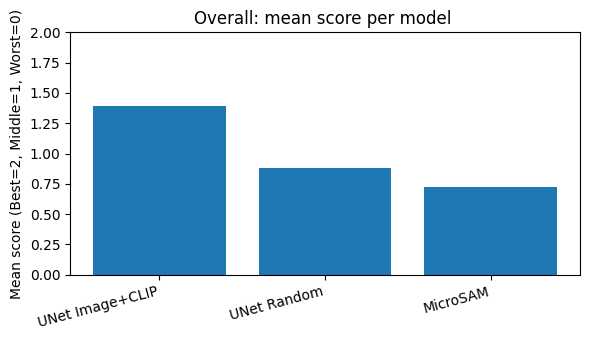

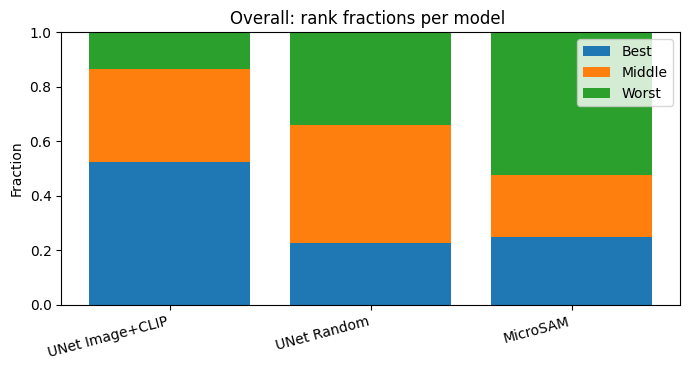

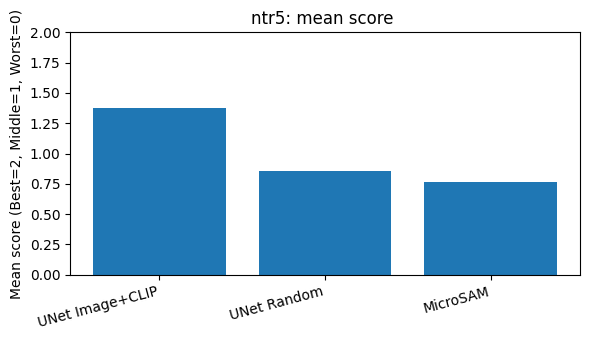

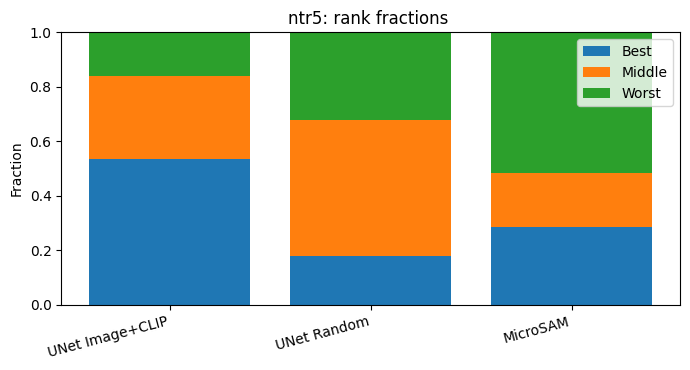

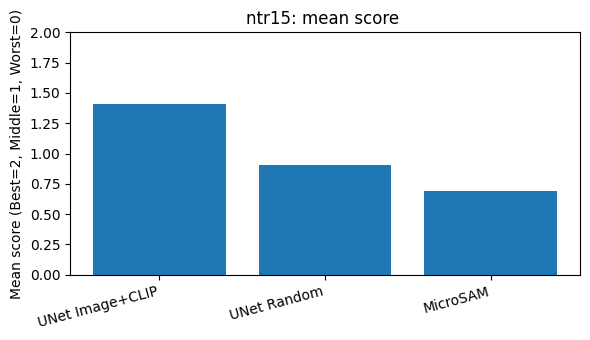

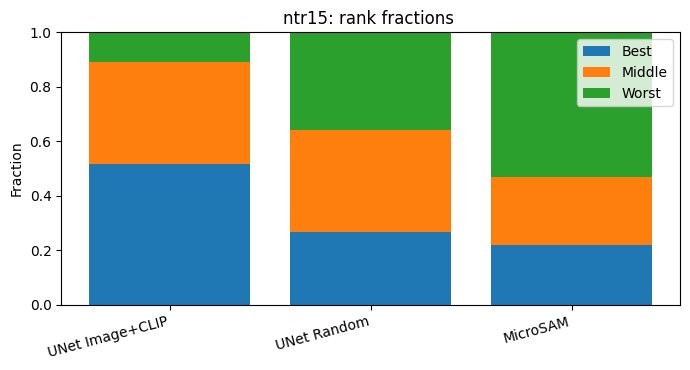

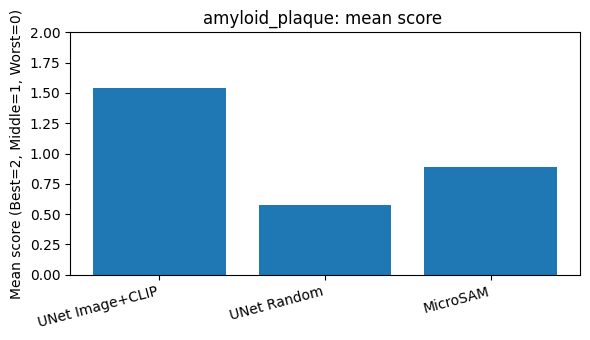

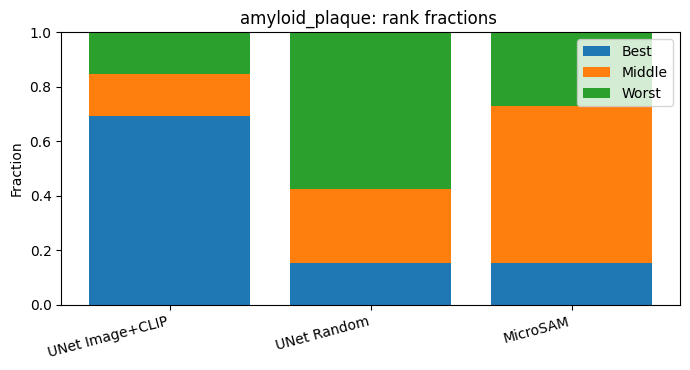

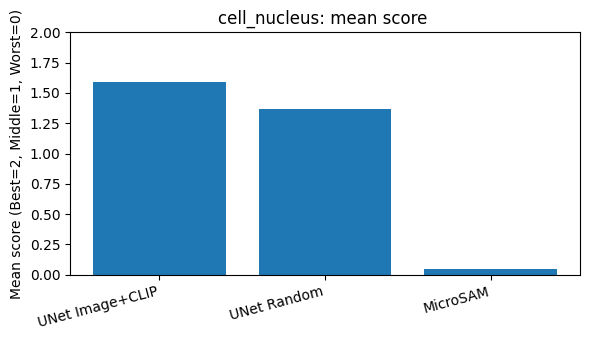

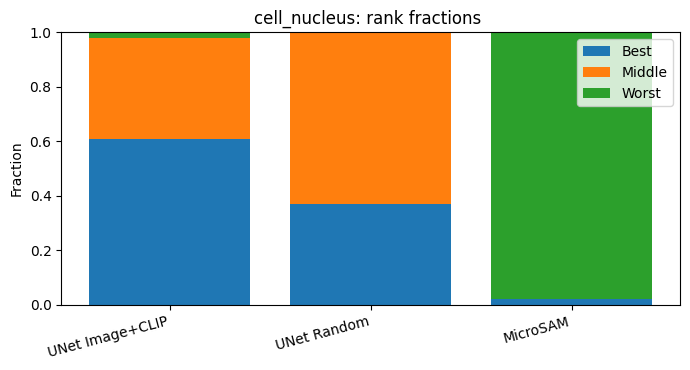

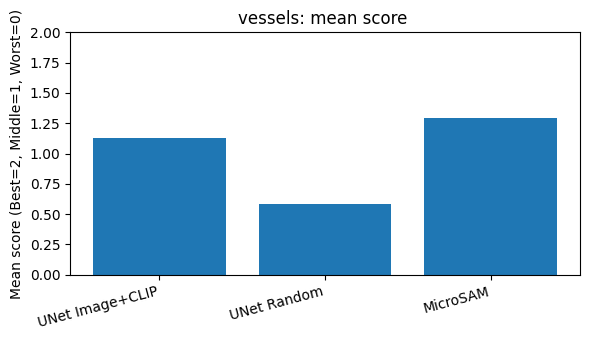

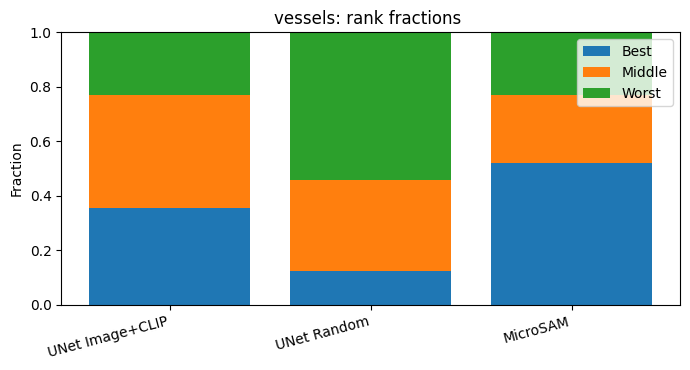

In [6]:
# ============================================================
# FILTER TO A SUBSET OF USERS (INCLUDE / EXCLUDE) + PLOT
# Assumes you already ran the earlier notebook cells and have:
#   - df  (wide responses)
#   - long (long format, one row per model per response)
# ============================================================

import numpy as np
import pandas as pd

# ---------
# 1) Choose your filter
# ---------

# Option A: include ONLY these users
INCLUDE_USERS = []   # <-- edit (or set to None)

# Option B: exclude these users
EXCLUDE_USERS = ["Adina"]              # <-- edit (or set to [])

# If you set INCLUDE_USERS to a non-empty list, EXCLUDE_USERS is ignored.

# ---------
# 2) Apply filter
# ---------

def filter_by_users(long_df: pd.DataFrame,
                    include_users
                    ,
                    exclude_users
                    ) -> pd.DataFrame:
    include_users = include_users or []
    exclude_users = exclude_users or []

    out = long_df.copy()

    if len(include_users) > 0:
        out = out[out["user_id"].isin(include_users)]
    elif len(exclude_users) > 0:
        out = out[~out["user_id"].isin(exclude_users)]

    return out.reset_index(drop=True)


long_filt = filter_by_users(long, include_users=INCLUDE_USERS, exclude_users=EXCLUDE_USERS)

print(f"Rows (long): {len(long)} total -> {len(long_filt)} after filtering")
print("Users included:", sorted(long_filt["user_id"].unique()))


# ---------
# 3) Re-use your existing plotting functions
#    (plot_mean_score, plot_rank_fractions)
# ---------

title_suffix = ""
# if INCLUDE_USERS:
#     title_suffix = f"(users = {', '.join(INCLUDE_USERS)})"
# elif EXCLUDE_USERS:
#     title_suffix = f"(excluding = {', '.join(EXCLUDE_USERS)})"
# else:
#     title_suffix = "(all users)"

plot_mean_score(long_filt, f"Overall: mean score per model {title_suffix}")
plot_rank_fractions(long_filt, f"Overall: rank fractions per model {title_suffix}")


# ---------
# 4) Same filters but split by ntr and datatype (optional)
# ---------

# ntr5 vs ntr15 separately
ntrs = sorted([int(x) for x in long_filt["ntr"].dropna().unique()])
for ntr in ntrs:
    sub = long_filt[long_filt["ntr"] == ntr]
    plot_mean_score(sub, f"ntr{ntr}: mean score {title_suffix}")
    plot_rank_fractions(sub, f"ntr{ntr}: rank fractions {title_suffix}")

# per datatype
datatypes = sorted(long_filt["datatype"].dropna().unique())
for dtype in datatypes:
    sub = long_filt[long_filt["datatype"] == dtype]
    plot_mean_score(sub, f"{dtype}: mean score {title_suffix}")
    plot_rank_fractions(sub, f"{dtype}: rank fractions {title_suffix}")
